# Import libs & download databases

In [ ]:
!pip install wfdb tqdm hrv-analysis
!pip install -Iv neurokit2==0.1.0

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import neurokit2 as nk
import wfdb
import keras
import scipy
import numpy as np
import pandas
from wfdb import plot
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import math
import hrvanalysis as hrvana
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
datafolder = "" # path to records database/путь до базы записей
files = os.listdir(datafolder)
filenames = list(set([datafolder+f.split('.')[0] for f in files]))

# Preparing dataset

In [ ]:
def create_dataset_by_person(series, window_size=4):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=window_size, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  return dataset

In [ ]:
def create_final_dataset(hrv_by_person, window_size=4):
  result_ds = None
  for person in hrv_by_person:
    step_ds = create_dataset_by_person(person, window_size)
    if(not result_ds):
      result_ds = step_ds
    else:
      result_ds = result_ds.concatenate(step_ds)
  return result_ds.batch(45).prefetch(1)

In [ ]:
training_data_threshold = int(0.8 * (len(filenames)-2))
data_path = "" # путь к файлу, содержащему подготовленные HRV-индексы
minmax_hrv_by_person = numpy.load(data_path)

In [ ]:
train_ds = create_final_dataset(minmax_hrv_by_person[:training_data_threshold])
valid_ds = create_final_dataset(minmax_hrv_by_person[training_data_threshold:])

# Model creation and training

Encoder-Decoder model

In [ ]:
def create_autoencoder(n_features, n_timesteps, step=0.25):
  step = int(n_features*step)

  keras.backend.clear_session()
  autoencoder = keras.models.Sequential()
  autoencoder.add(keras.layers.LSTM(n_features, input_shape=(n_timesteps, n_features), return_sequences=True))
  autoencoder.add(keras.layers.LSTM(n_features-step, return_sequences=True))
  autoencoder.add(keras.layers.LSTM(n_features - step*2, return_sequences=False))
  autoencoder.add(keras.layers.RepeatVector(1))
  autoencoder.add(keras.layers.LSTM(n_features-step, return_sequences=True))
  autoencoder.add(keras.layers.LSTM(n_features, return_sequences=True))
  autoencoder.add(keras.layers.TimeDistributed(keras.layers.Dense(n_features)))

  optim = tf.keras.optimizers.Adam(learning_rate=0.001)

  autoencoder.compile(loss=tf.keras.losses.Huber(), optimizer=optim, metrics=["mse", "mae"])
  return autoencoder

In [ ]:
autoencoder_12f = create_autoencoder(12, 3)
autoencoder_12f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 12)             1200      
                                                                 
 lstm_1 (LSTM)               (None, 3, 9)              792       
                                                                 
 lstm_2 (LSTM)               (None, 6)                 384       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 6)             0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 1, 9)              576       
                                                                 
 lstm_4 (LSTM)               (None, 1, 12)             1056      
                                                        

In [ ]:
autoencoder_48f = create_autoencoder(48, 3)
autoencoder_48f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 48)             18624     
                                                                 
 lstm_1 (LSTM)               (None, 3, 36)             12240     
                                                                 
 lstm_2 (LSTM)               (None, 24)                5856      
                                                                 
 repeat_vector (RepeatVector  (None, 1, 24)            0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 1, 36)             8784      
                                                                 
 lstm_4 (LSTM)               (None, 1, 48)             16320     
                                                        

In [ ]:
EPOCH_COUNT = 100
history = autoencoder_12f.fit(train_ds, epochs=EPOCH_COUNT, validation_data=valid_ds)

In [ ]:
# saving
save_path_48f = "" # путь до папки, в которую будет сохранена модель для предсказания 48 признаков
save_path_12f = "" # путь до папки, в которую будет сохранена модель для предсказания 12 признаков
autoencoder_48f.save(save_path_48f)
autoencoder_12f.save(save_path_12f)

In [ ]:
#plot loss/график потери(mse) 
def plot_loss(history):
    figure(figsize=(10, 8))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

# plot mae/график mae 
def plot_mae(history):
  figure(figsize=(10, 8))
  plt.plot(history.history['mae'], label='train')
  plt.plot(history.history['val_mae'], label='test')
  plt.title('model MAE')
  plt.ylabel('MAE')
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()

In [ ]:
plot_loss(history)

In [ ]:
plot_mae(history)

 # Functions for processing 

Slice record into 5 min length samples

In [ ]:
def slice_record_to_5min_intervals(filename, intervals_max_count=180):
    """ Читает запись и делит её на последовательные пятиминутные отрезки,
        их максимальное количество = intervals_max_count
        Args:
            filename: string, полный путь до записи без расширения
            intervals_max_count: int, максимальное количество интервалов, 
                на которые делить запись. Если она короче - вернет меньше интервалов
        Returns:
            list of lists: внутренние списки - списки сэмплов, входящих в интервалы
    """
    print("Now slicing record with path : " + filename)
    annotation = wfdb.rdann(filename,"atr")
    fs = annotation.fs
    sample = annotation.sample
    record = wfdb.rdrecord(filename)    
    signal = record.__dict__["p_signal"][sample[0]:sample[-1], 0]
    
    #return slice_signal_to_5min_intervals(signal, fs)
    return slice_intersected_5min_intervals(signal, fs)

In [ ]:
def slice_signal_to_5min_intervals(signal, sampling_freq, intervals_max_count = 180):
    """ Делит сигнал на последовательные пятиминутные отрезки,
        их максимальное количество = intervals_max_count
        Args: 
            signal: list-like, сигнал для деления
            sampling_freq: int, частота дискретизации(Гц)
            intervals_max_count: int,  максимальное количество интервалов, 
                на которые делить запись. Если она короче - вернет меньше интервалов
        Returns:
            list of lists: внутренние списки - списки сэмплов, входящих в интервалы
            максимальная длина внешнего списка = intervals_max_count
    """
    interval_length = 5 * 60 * sampling_freq
    signal_slices = []
    
    for i in range(0, len(signal), interval_length):
        if (len(signal_slices) >= intervals_max_count):
            break
        signal_slices.append(signal[i:i + interval_length]) 

    return signal_slices

In [ ]:
def slice_intersected_5min_intervals(signal, sampling_freq, intervals_max_count = 250, shift_minutes = 1):
    """ Делит сигнал на пересекающиеся 5-минутные отрезки 
        Args: 
            signal: list-like, сигнал
            sampling_freq: int, частота дискретизации(Гц)
            intervals_max_count: int, максимальное количество интервалов на возвращение,
                может вернуть меньше указанного значения
            shift_minutes: int > 0, шаг, примеры:
                если 1, то возвратит интервалы 0-5, 1-6, 2-7 и т.д.
                если 2, то интервалы 0-5, 2-7, 4-9 и т.д.
        Returns:
            list of lists - внутренние списки - сэмплы на 5 минут,
            максимальное len() внешнего списка = intervals_max_count
    """
    interval_length = 5 * 60 * sampling_freq
    shift = shift_minutes * 60 * sampling_freq
    signal_slices = []
    
    for i in range(0, len(signal), shift):
        if (len(signal_slices) >= intervals_max_count):
            break
        current_slice = signal[i:i + interval_length]
        signal_slices.append(current_slice)

    return signal_slices

Get peaks and HRV array

In [ ]:
def wave_to_peaks(signal, fs):
    """ Декоратор (Wrapper function) neurokit's 'ecg_findpeaks' и 'ecg_clean'.
        Очищает сигнал и возвращает сэмплы, на которых найдены R-пики,
        как в документации neurokit по функциям.
        Args: 
            signal: list-like, сигнал
            fs: int, частота дискретизации(Гц)
        Returns:
            dict, доступ к пикам по ключу 'ECG_R_Peaks'
    """
    signal = hrvana.interpolate_nan_values(rr_intervals=signal,interpolation_method="linear")
    cleaned = nk.ecg_clean(signal, sampling_rate = fs)
    peaks = nk.ecg_findpeaks(cleaned, sampling_rate=fs, show=False)['ECG_R_Peaks']
    
    return peaks

In [ ]:
EXCLUDED_COLUMNS = ['HRV_ULF', 'HRV_VLF', 'HRV_CSI_Modified', 'HRV_S']
INCLUDED_COLUMNS = ['HRV_pNN50', 'HRV_CVI', 'HRV_HTI', 'HRV_CVNN', 'HRV_ApEn', 'HRV_SampEn', 
                    'HRV_SD1SD2', 'HRV_LFHF', 'HRV_IALS', 'HRV_PAS', 'HRV_PI', 'HRV_AI'] # выбранные 12 признаков
SAMPLING_FREQ = 128

In [ ]:
def get_specified_hrv(rri, fs, hrv_indices):
    """ Возвращает указанные показатели HRV
        Args:
            rri: dict, доступ к пикам по ключу 'ECG_R_Peaks'
            fs: int, частота дискретизации(Гц)
            hrv_indices: list, список HRV-показателей
        Returns:
            1-мерный numpy массив значений указанных показателей
    """
    clean_rri = rri*(1000/fs)
    clean_rri = hrvana.remove_ectopic_beats(rr_intervals=clean_rri, method="malik")
    clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri,interpolation_method="linear")

    clean_rri = np.array(clean_rri)
    clean_rri = clean_rri[~np.isnan(clean_rri)]
    
    peaks_unec = np.zeros(len(clean_rri)+1)
    cv = 0

    for count, value in enumerate(clean_rri):
        cv += value
        peaks_unec[count+1] = cv

    peaks_unec *= (128.0/1000.0)   
    rpeaks = {'ECG_R_Peaks':peaks_unec}
    hrv_full = nk.hrv(rpeaks, sampling_rate=128, show=False)
    target_hrvs = hrv_full[hrv_indices]
    return np.ravel(target_hrvs.to_numpy())

def rpeaks_to_hrv(rri, fs):
    """ Возвращает HRV значения из R-пиков
        Args:
            rri: dict, доступ к пикам по ключу 'ECG_R_Peaks'
            fs: int, частота дискретизации(Гц)
        Returns:
            1-мерный массив показателей
    """
    clean_rri = rri*(1000/fs)
    clean_rri = hrvana.remove_ectopic_beats(rr_intervals=clean_rri, method="malik")
    clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri,interpolation_method="linear")

    clean_rri = np.array(clean_rri)
    clean_rri = clean_rri[~np.isnan(clean_rri)]
    
    peaks_unec = np.zeros(len(clean_rri)+1)
    cv = 0

    for count, value in enumerate(clean_rri):
        cv += value
        peaks_unec[count+1] = cv

    peaks_unec *= (128.0/1000.0)   
    rpeaks = {'ECG_R_Peaks':peaks_unec}
    hrvdat = nk.hrv(rpeaks, sampling_rate=128, show=False)
    hrvdat = hrvdat.drop(columns = EXCLUDED_COLUMNS)
    indices = np.ravel(hrvdat.to_numpy())
    
    return indices

Normalize the HRV values

In [ ]:
def flatten_1stlevel(list_of_lists_of_lists):
    """ >>> flatten_1stlevel([[[1, 2], [3, 4]],[[5, 6], [7, 8]],[[9, 0]]])
        [[1, 2], [3, 4], [5, 6], [7, 8], [9, 0]]
        >>> flatten_1stlevel([[1, 2], [[3,4], [[5, 6], 7]], []])
        [1, 2, [3, 4], [[5, 6], 7]]
        >>> flatten_1stlevel([[1, 2], [3, 4]])
        [1, 2, 3, 4]
        >>> flatten_1stlevel([1, 2, 3])
        [1, 2, 3]
    """
    flat_1stlevel = []
    
    for list_of_lists in list_of_lists_of_lists:
        try:
            flat_1stlevel.extend(list_of_lists)
        except TypeError:
            flat_1stlevel.append(list_of_lists)

    return flat_1stlevel

    
def standardize_hrv_values(hrv_arrays, return_scaler=False):
    """ Нормализует значения показателей с помощью MinMaxScaler
        Args:
            hrv_arrays: list of arrays, список массивов показателей по пациенту, структура:
            [[[1, 2], [3, 4]],[[5, 6], [7, 8]],[[9, 0], [10, 11]]]
            return_scaler: bool, true - возвращает обученный MinMaxScaler
        Returns:
            (всегда) list of numpy arrays - стандартизированных значений,
            if return_scaler - также возвратит MinMaxScaler

    """
    scaler = MinMaxScaler()
    person_hrvs_count = len(hrv_arrays) # количество пациентов
    all_hrvs = flatten_1stlevel(hrv_arrays)
    scaler = scaler.fit(all_hrvs)
    std_hrvs = scaler.transform(all_hrvs)
    
    if not return_scaler:
        return np.split(std_hrvs, person_hrvs_count)
    
    return np.split(std_hrvs, person_hrvs_count), scaler

# Prediction of next HRV

In [ ]:
load_path_12f = "" # путь до папки, из которой загрузить модель для 12 признаков
load_path_48f = "" # путь до папки, из которой загрузить модель для 48 признаков
loaded_model_12f = tf.keras.models.load_model(load_path_12f)
loaded_model_48f = tf.keras.models.load_model(load_path_48f)
test_file = "" # путь к тестовому файлу

In [ ]:
def get_random_samples(test_record, count=1):
  intervals = slice_record_to_5min_intervals(test_record)
  indiсes = np.random.randint(4, len(intervals), count)
  return np.array([intervals[index-4:index] for index in indiсes])

def get_prediction(model, samples, indices='all'):
  hrvs = []
  for sample in samples:
    for five_min in sample:
      rpeaks = wave_to_peaks(five_min, SAMPLING_FREQ)
      rri = np.diff(rpeaks)
      if(indices == 'spec'):
        hrv = get_specified_hrv(rri, SAMPLING_FREQ, INCLUDED_COLUMNS)
      else:
        hrv = rpeaks_to_hrv(rri, SAMPLING_FREQ)
      hrvs.append(hrv)
  hrvs = np.array_split(hrvs, samples.shape[0])
  
  norm_hrvs, scaler = standardize_hrv_values(hrvs, True)
  hrvs = np.array(hrvs)
  norm_hrvs = np.array(norm_hrvs)

  predictions, real = [], []
  for index, sample in enumerate(norm_hrvs):
    test_data = np.expand_dims(sample[:3], axis=0)
    prediction = model.predict(test_data)
    real.append(hrvs[index][3])
    predictions.append(scaler.inverse_transform(prediction[0]))

  return predictions, real

In [ ]:
samples = get_random_samples(test_file, count=30)

In [ ]:
preds_12f, real_12f = get_prediction(loaded_model_12f, samples, indices='spec')

In [ ]:
preds_48f, real_48f = get_prediction(loaded_model_48f, samples)

In [ ]:
print(f'Real:\n{real_12f[5]}')
print(f'Predicted:\n{preds_12f[5]}')

Real:
[5.17307692e+01 5.11044250e+00 6.84210526e+00 1.96964675e-01
 1.23782439e+00 1.55782167e+00 3.64273690e-01 1.59178971e+00
 4.16000000e-01 5.16129032e-02 5.00000000e+01 4.96512799e+01]
Predicted:
[[5.6421619e+01 4.9782567e+00 6.3438420e+00 1.7343824e-01 1.2306471e+00
  1.3258259e+00 3.4122321e-01 4.3546844e-01 4.2119041e-01 2.2534981e-02
  4.9912563e+01 5.0128860e+01]]


In [ ]:
#статистика относительной ошибки
def calc_divergence(predictions, real_hrvs):
  result = 0
  for ind, prediction in enumerate(predictions): 
    divergence = np.absolute(prediction[0] - real_hrvs[ind])
    divergence = np.absolute(divergence / real_hrvs[ind]) 
    result += np.nan_to_num(divergence.flatten(), nan=1.0, posinf=1.0, neginf=1.0)
  result /= len(real_hrvs)
  return result

In [ ]:
intrvls = slice_record_to_5min_intervals(test_file)
rpeaks = wave_to_peaks(intrvls[0], SAMPLING_FREQ)
df = nk.hrv(rpeaks, SAMPLING_FREQ).drop(columns = EXCLUDED_COLUMNS)  
names = list(map(lambda n: n[4:], df.columns))
print(df.columns)

#Визуализация 

In [ ]:
indices = [i for i in range(48)]

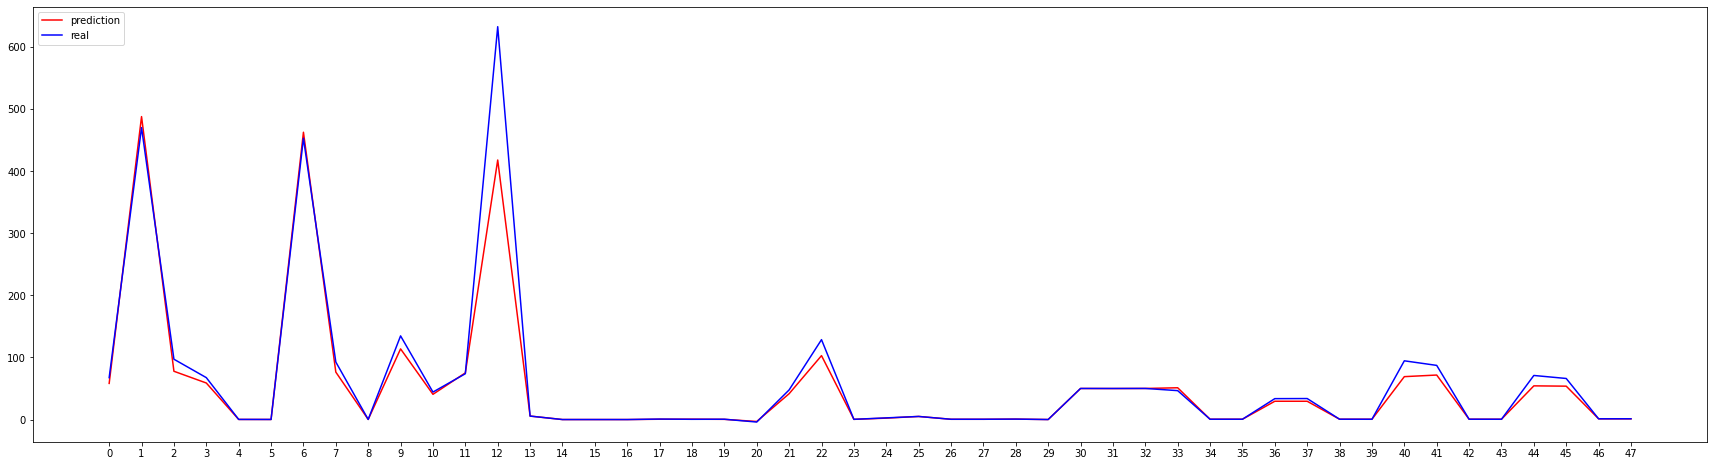

In [ ]:
figure(figsize=(30, 8))
plt.plot(preds_48f[6][0], 'r')
plt.plot(real_48f[6], 'b')
plt.legend(['prediction', 'real'], loc='upper left')
plt.xticks(indices, indices)
plt.show()

In [ ]:
# индексы по значениям
medium = [0,2,3,7,9,10,11,21,22,30,31,32,33,36,37,40,41,44,45] # значения в пределах нескольких десятков
high = [1,6,12] # самые большие значения -  высокие пики на графике
small = [13, 20, 25, 46, 47] # значения до 10
tiny1 = [17,18,19,23,24,26,27,28,29,34,35,38,39,42,43] # в пределах 1
tiny2 = [4,5,8,14,15,16] # меньше 0.5

In [ ]:
def plot_specified_ind(pred_vals, real_vals, indices, shortlist=False):
    figure(figsize=(12, 7))
    new_indices = range(len(indices))
    pr_points = [pred_vals[x] for x in indices]
    real_vals = [real_vals[x] for x in indices]
    if shortlist:
        x_names = [INCLUDED_COLUMNS[x] for x in indices]
    else:
        x_names = [names[x] for x in indices]
    width = 0.5
    offset = width/2
    plt.bar(new_indices, pr_points, width)
    plt.bar([i+offset for i in new_indices], real_vals, width)
    plt.legend(['prediction', 'real'], loc='upper right')
    plt.xticks(new_indices, x_names, rotation=30)

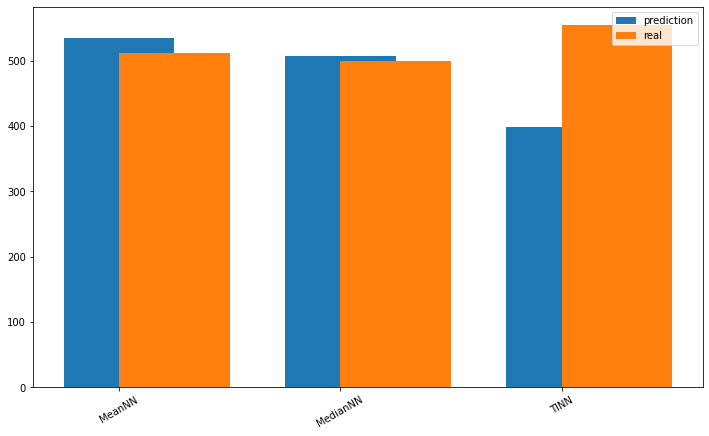

In [ ]:
plot_specified_ind(preds_48f[0][0], real_48f[0], high)

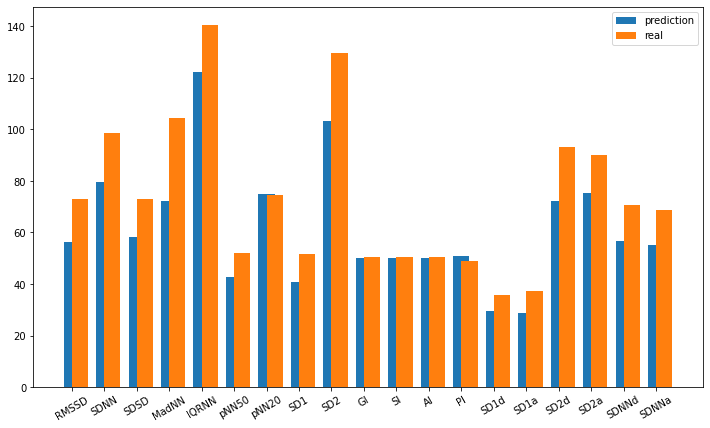

In [ ]:
plot_specified_ind(preds_48f[0][0], real_48f[0], medium)

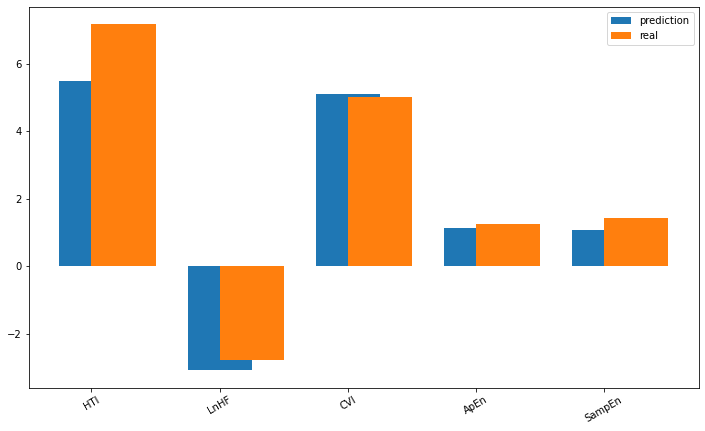

In [ ]:
plot_specified_ind(preds_48f[0][0], real_48f[0], small)

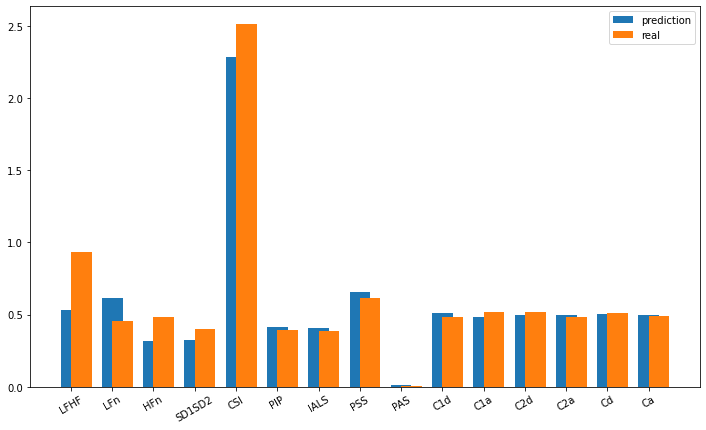

In [ ]:
plot_specified_ind(preds_48f[0][0], real_48f[0], tiny1)

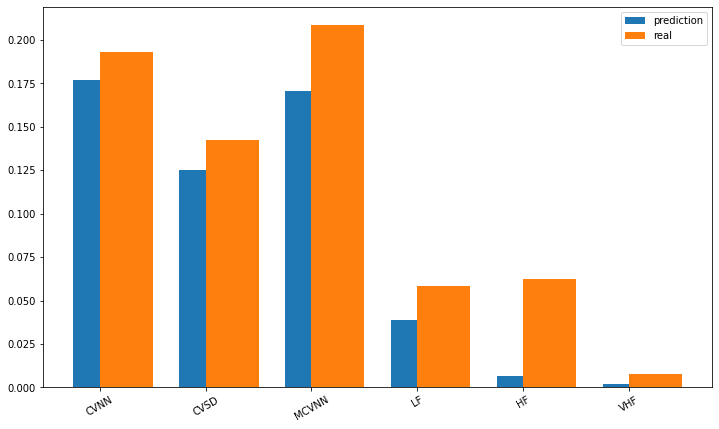

In [ ]:
plot_specified_ind(preds_48f[0][0], real_48f[0], tiny2)

<h2>Визуализация с imshow</h2>

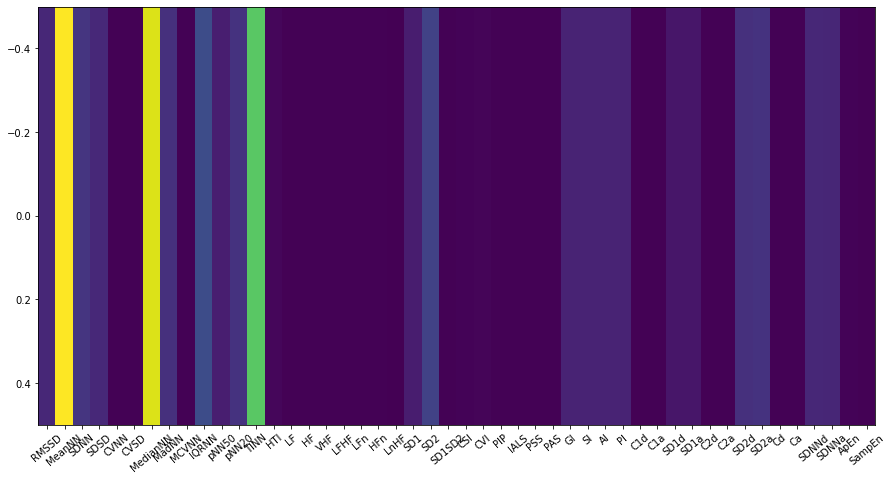

In [ ]:
figure(figsize=(15, 8))
plt.imshow(preds_48f[0], aspect=48/2)
plt.xticks(indices, names, rotation=40)
plt.show()

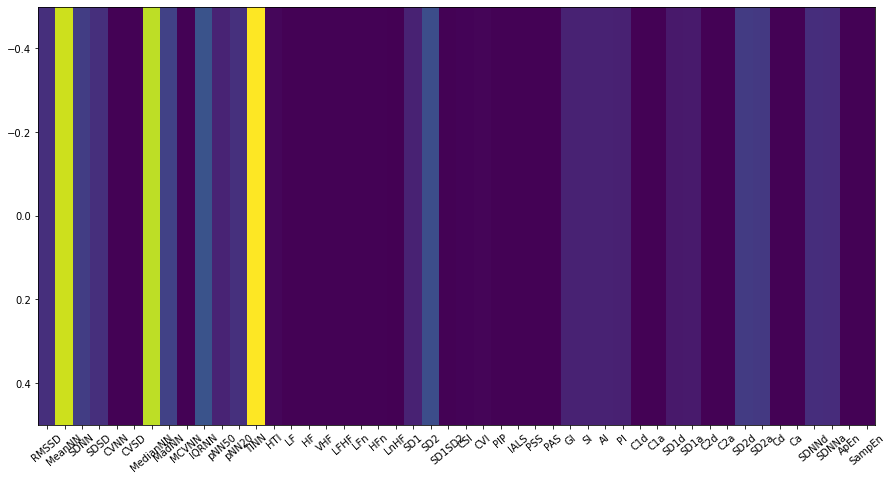

In [ ]:
figure(figsize=(15, 8))
plt.imshow([real_48f[0]], aspect=48/2)
plt.xticks(indices, names, rotation=40)
plt.show()

In [ ]:
rel_error48 = calc_divergence(preds_48f, real_48f)
rel_error12 = calc_divergence(preds_12f, real_12f)

In [ ]:
#функции для визуализации относительной ошибки
def rel_err_plot(pred_val, real_val, columns):
  figure(figsize=(20, 5))
  fr_vals =  calc_divergence(pred_val, real_val)
  plt.xticks(indices[:len(columns)], columns, rotation=30)
  plt.bar(indices[:len(columns)], height=fr_vals)

def rel_err_imshow(pred_val, real_val, columns):
  figure(figsize=(30, 10))
  plt.xticks(indices[:len(columns)], columns, rotation=30)
  plt.imshow([calc_divergence(pred_val, real_val)*255], aspect=len(columns)/2, cmap='gray', vmin=0, vmax=255) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


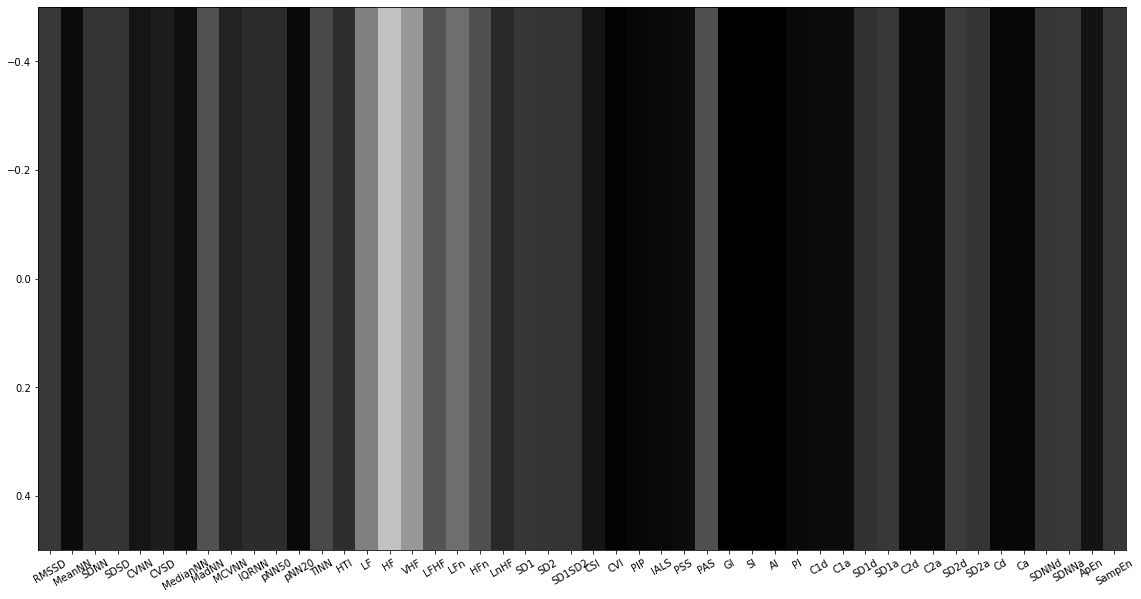

In [ ]:
# для 48 признаков
rel_err_imshow(preds_48f, real_48f, names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


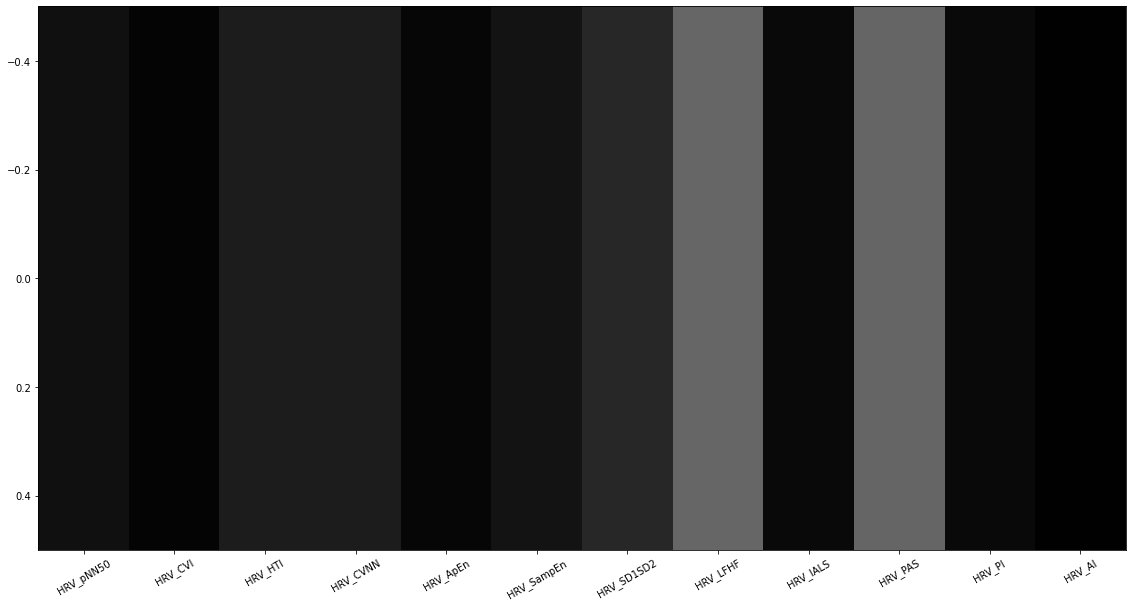

In [ ]:
# для 12 признаков
rel_err_imshow(preds_12f, real_12f, INCLUDED_COLUMNS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


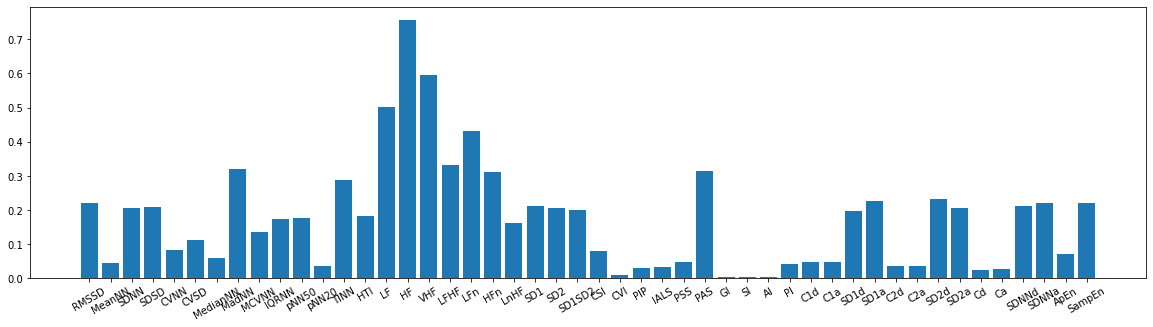

In [ ]:
# относительная ошибка в долях
rel_err_plot(preds_48f, real_48f, names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


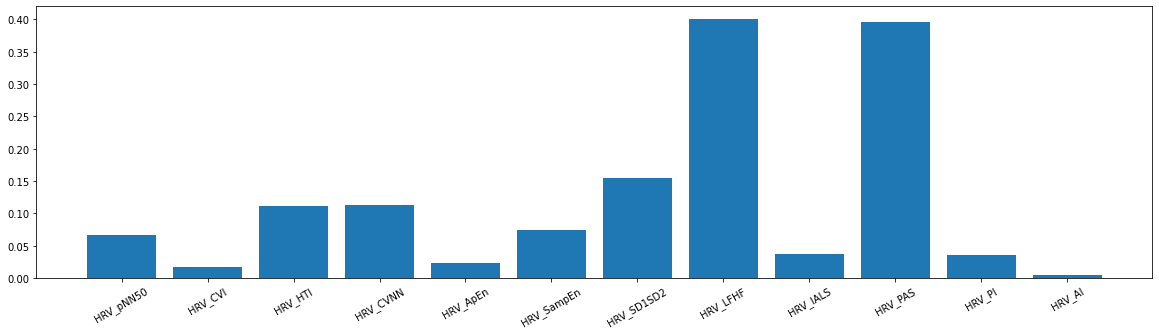

In [ ]:
rel_err_plot(preds_12f, real_12f, INCLUDED_COLUMNS)

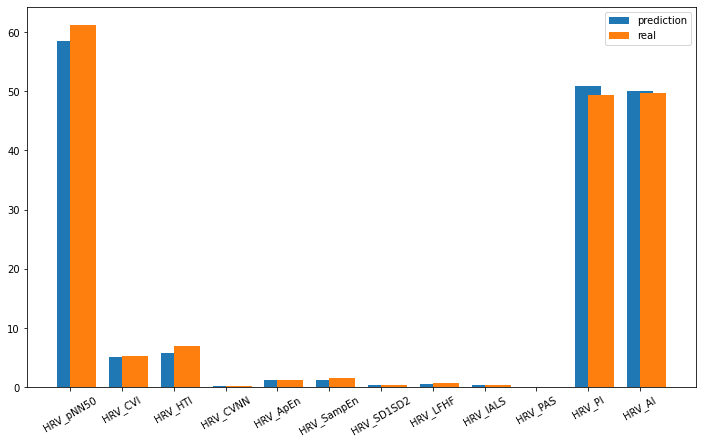

In [ ]:
# сравнение пресдказаний и реальных значений для 12 выбранных признаков
plot_specified_ind(preds_12f[5][0], real_12f[5], range(12), True)

In [ ]:
selection = np.zeros(len(rel_error12))
for idx, val in enumerate(df.columns): 
    try:
        position = INCLUDED_COLUMNS.index(val)
        selection[position] = rel_error48[idx]
    except ValueError:
        pass

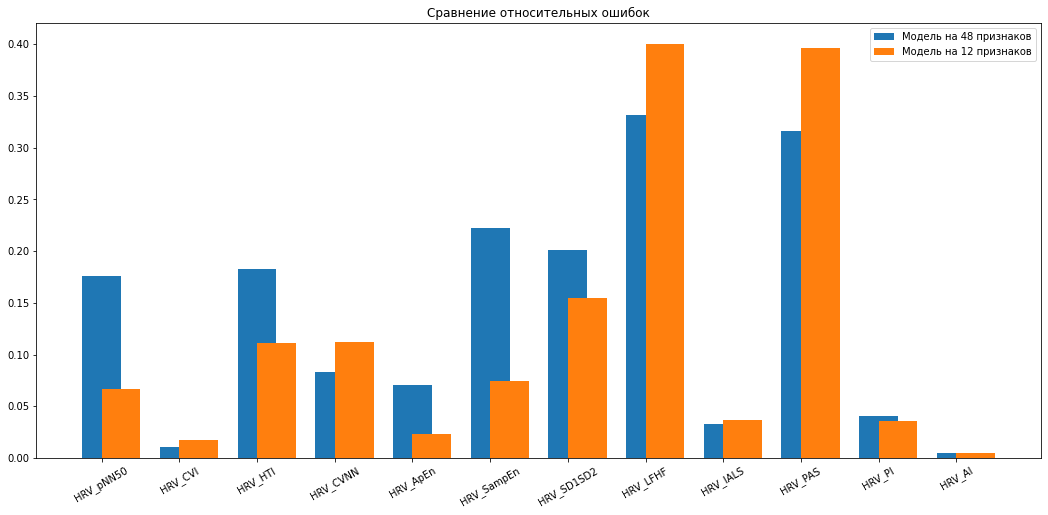

In [ ]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
figure(figsize=(18, 8))
width = 0.5
offset = width/2
plt.bar(indices[:12], selection, width, label="Модель на 48 признаков")
plt.bar([i+offset for i in indices[:12]], rel_error12, width, label="Модель на 12 признаков")
plt.xticks(ticks=indices[:12], labels=INCLUDED_COLUMNS, rotation=30)
plt.title("Сравнение относительных ошибок")
plt.legend(["Модель на 48 признаков", "Модель на 12 признаков"])
plt.show()